In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from IPython.display import Image

# import jupyter_black
# jupyter_black.load()

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

np.set_printoptions(2)

# filter out Seaborn UserWarnings
warnings.filterwarnings(action="ignore", category=UserWarning, module=r"seaborn")
# warnings.filterwarnings(action="ignore", category=RuntimeWarning, module=r"scipy")
from warnings import simplefilter, warn

simplefilter("ignore")

In [2]:
import os
os.getcwd()

'/Users/gireeshramji/PycharmProjects/SouthridgeCorp/player-outcome-predictor/notebooks'

In [3]:
os.chdir("..")
os.getcwd()

'/Users/gireeshramji/PycharmProjects/SouthridgeCorp/player-outcome-predictor'

In [4]:
from utils.config_utils import ConfigUtils
from historical_data.singleton import Helper
from data_selection.data_selection import DataSelection
from rewards_configuration.rewards_configuration import RewardsConfiguration
from simulators.perfect_simulator import PerfectSimulator

In [5]:
config_utils = ConfigUtils(".streamlit/config.toml")
helper = Helper(config_utils)
data_selection = DataSelection(helper)
rewards_config = RewardsConfiguration(config_utils)
perfect_simulator = PerfectSimulator(data_selection, rewards_config)

2022-11-11 11:11:11.826 INFO    root: Creating feedback form storage with method local


In [6]:
all_matches = data_selection.get_all_matches()

In [7]:
start_date = all_matches.date.min()
end_date = all_matches.date.max()

In [8]:
helper.tournaments.set_selected_tournament_names(helper.tournaments.df['name'].to_list())

In [9]:
helper.tournaments.set_start_end_dates(start_date, end_date, True)

In [10]:
bowling_outcomes_df = perfect_simulator.get_bowling_outcomes_by_ball_and_innings(True)

In [11]:
bowling_outcomes_df.shape

(1258544, 20)

In [12]:
bowling_outcomes_categorical = pd.Categorical(bowling_outcomes_df.bowling_outcome_index)
    #bowling_outcomes_idx, \
    #bowling_outcomes = bowling_outcomes_by_ball_and_innings_df.bowling_outcome_index.factorize(sort=True)
bowling_outcomes_idx = bowling_outcomes_categorical.codes
bowling_outcomes = bowling_outcomes_categorical.categories

In [13]:
bowling_outcomes

Index(['0', '1-b', '1-b,1-nb', '1-b,1-nb,W-dro', '1-b,1-nb,W-idro', '1-b,1-w',
       '1-b,12-oe', '1-b,2-oe', '1-b,2-oe,W-dro', '1-b,2-oe,W-others',
       '1-b,5-oe', '1-b,6-oe', '1-b,W-dro', '1-b,W-idro', '1-b,W-others',
       '1-nb', '1-nb,W-dro', '1-nb,W-idro', '1-nb,W-others', '1-oe',
       '1-oe,W-dro', '1-oe,W-idro', '1-oe,W-others', '1-w', '1-w,W-bs',
       '1-w,W-dro', '1-w,W-idro', '1-w,W-others', '2-b', '2-b,1-nb',
       '2-b,2-oe', '2-b,5-oe', '2-b,6-oe', '2-b,W-dro', '2-b,W-idro',
       '2-b,W-others', '2-nb', '2-oe', '2-oe,W-dro', '2-oe,W-others', '3-b',
       '3-b,1-nb', '3-b,2-oe', '3-b,W-dro', '3-b,W-idro', '3-b,W-others',
       '3-nb', '3-oe', '4-b', '4-b,1-nb', '4-b,2-oe', '4-b,W-dro',
       '4-b,W-idro', '4-b,W-others', '4-nb', '4-oe', '5-b', '5-nb', '5-oe',
       '5-oe,W-others', '6-b', '6-b,1-nb', '6-b,2-oe', '6-b,6-oe',
       '6-b,W-others', '6-oe', '7-b', '7-oe', 'W-b', 'W-bc', 'W-bs', 'W-dro',
       'W-idro', 'W-others'],
      dtype='object')

In [14]:
batter_runs_categorical = pd.Categorical(bowling_outcomes_df.batter_runs)

In [15]:
batter_runs_idx, batter_runs_outcomes = batter_runs_categorical.codes, batter_runs_categorical.categories

In [16]:
batter_runs_outcomes

Int64Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int64')

In [17]:
batter_runs_idx

array([0, 1, 0, ..., 0, 0, 2], dtype=int8)

In [18]:
all_dates = all_matches.date.sort_values().tolist()

In [19]:
train_idx = 10

In [20]:
train_start_date = all_dates[0]
train_end_date = all_dates[train_idx-1]
helper.tournaments.set_start_end_dates(train_start_date, train_end_date, False)

In [21]:
test_start_date = all_dates[train_idx]
test_end_date = all_dates[train_idx+100]
helper.tournaments.set_start_end_dates(test_start_date, test_end_date, True)

In [22]:
test_start_date

datetime.date(2006, 12, 26)

In [23]:
def get_innings_data(bowling_outcomes_df, match_state_df, inning):
    bowling_outcomes_innings_df = bowling_outcomes_df.query(f'inning == {inning}')
    match_state_innings_df = match_state_df.query(f'inning == {inning}')
    return bowling_outcomes_innings_df, match_state_innings_df

In [24]:
train_bowling_outcomes_by_ball_and_innings_df = perfect_simulator.get_bowling_outcomes_by_ball_and_innings(False)

In [25]:
train_match_state_df = perfect_simulator.get_match_state_by_ball_and_innings(False)
train_first_innings_dfs = get_innings_data(train_bowling_outcomes_by_ball_and_innings_df,
                                     train_match_state_df,
                                     inning=1)

In [26]:
test_bowling_outcomes_by_ball_and_innings_df = perfect_simulator.get_bowling_outcomes_by_ball_and_innings(True)

In [27]:
test_match_state_df = perfect_simulator.get_match_state_by_ball_and_innings(True)
test_first_innings_dfs = get_innings_data(test_bowling_outcomes_by_ball_and_innings_df,
                                     test_match_state_df,
                                     inning=1)

In [28]:
train_bowling_outcomes_idx = pd.Categorical(train_first_innings_dfs[0].bowling_outcome_index,
                                              categories = bowling_outcomes).codes

In [29]:
train_bowling_outcomes_idx

array([ 0,  1,  0, ..., 72, 19, 28], dtype=int8)

In [30]:
train_batter_runs_outcomes_idx = pd.Categorical(train_first_innings_dfs[0].batter_runs,
                                                categories = batter_runs_outcomes).codes

In [31]:
train_batter_runs_outcomes_idx.shape

(1241,)

In [32]:
COORDS = {
    "bowling_outcomes": bowling_outcomes,
    "ball_ids": np.arange(train_first_innings_dfs[0].shape[0]),
    "batter_runs_outcomes": batter_runs_outcomes
}

In [33]:
COORDS['ball_ids']

array([   0,    1,    2, ..., 1238, 1239, 1240])

In [34]:
import aesara.tensor as at

In [35]:
train_first_innings_dfs[1].columns

Index(['batter', 'bowler', 'batting_team', 'total_runs', 'is_wicket',
       'target_runs', 'target_overs', 'batting_featured_player',
       'bowling_featured_player', 'venue',
       ...
       'bowler_VSi1816', 'bowler_WHs2418', 'bowler_WTa1105', 'batter_WVs1108',
       'bowler_YKn911', 'batter_ZKn743', 'total_balls_bowled', 'current_total',
       'wickets_fallen', 'runs_to_target'],
      dtype='object', length=290)

#Is the delivery legal or not

In [36]:
train_first_innings_dfs[0]

batter_runs  extras  total_runs non_boundary  \
match_key inning over ball                                                 
211028    1      0    1               0       0           0          NaN   
                      2               1       0           1          NaN   
                      3               0       0           0          NaN   
                      4               0       0           0          NaN   
                      5               0       0           0          NaN   
...                                 ...     ...         ...          ...   
255954    1      19   2               1       0           1          NaN   
                      3               0       0           0          NaN   
                      4               0       0           0          NaN   
                      5               0       1           1          NaN   
                      6               2       0           2          NaN   

                            is_wicket dismissal_kind  is_direct_runout  byes  \
match_key inning over ball                                                     
211028    1      0    1             0            NaN               NaN   NaN   
                      2             0            NaN               NaN   NaN   
                      3             0            NaN               NaN   NaN   
                      4             0            NaN               NaN   NaN   
                      5             0            NaN               NaN   NaN   
...                               ...            ...               ...   ...   
255954    1      19   2             0            NaN               NaN   NaN   
                      3             0            NaN               NaN   NaN   
                      4             1        run out               0.0   NaN   
                      5             0            NaN               NaN   NaN   
                      6             0            NaN               NaN   NaN   

                            legbyes  noballs  penalty  wides player_dismissed  \
match_key inning over ball                                                      
211028    1      0    1         NaN      NaN      NaN    NaN              NaN   
                      2         NaN      NaN      NaN    NaN              NaN   
                      3         NaN      NaN      NaN    NaN              NaN   
                      4         NaN      NaN      NaN    NaN              NaN   
                      5         NaN      NaN      NaN    NaN              NaN   
...                             ...      ...      ...    ...              ...   
255954    1      19   2         NaN      NaN      NaN    NaN              NaN   
                      3         NaN      NaN      NaN    NaN              NaN   
                      4         NaN      NaN      NaN    NaN          THn2630   
                      5         1.0      NaN      NaN    NaN              NaN   
                      6         NaN      NaN      NaN    NaN              NaN   

                             bowler   batter fielder non_striker  \
match_key inning over ball                                         
211028    1      0    1      BLe850  MTk1695     NaN     GJs1815   
                      2      BLe850  MTk1695     NaN     GJs1815   
                      3      BLe850  GJs1815     NaN     MTk1695   
                      4      BLe850  GJs1815     NaN     MTk1695   
                      5      BLe850  GJs1815     NaN     MTk1695   
...                             ...      ...     ...         ...   
255954    1      19   2     STr2632  RTs2631     NaN     THn2630   
                      3     STr2632  THn2630     NaN     RTs2631   
                      4     STr2632  THn2630  MDi608     RTs2631   
                      5     STr2632  CLt1049     NaN     RTs2631   
                      6     STr2632  RTs2631     NaN     CLt1049   

                            batting_team bowling_team bowli

In [41]:
def is_legal_delivery(row):
    return np.isnan(row['noballs']) and np.isnan(row['wides'])

In [45]:
def add_is_legal(df):
    df['is_legal_delivery'] = df.apply(is_legal_delivery,
                                       axis=1)

add_is_legal(train_first_innings_dfs[0])

In [47]:
train_first_innings_dfs[0].is_legal_delivery.value_counts()

True     1197
False      44
Name: is_legal_delivery, dtype: int64

In [50]:
data = pd.DataFrame({"wickets_fallen": train_first_innings_dfs[1].wickets_fallen,
                     "current_total": train_first_innings_dfs[1].current_total,
                     "total_balls_bowled": train_first_innings_dfs[1].total_balls_bowled,
                     "batter_runs": train_first_innings_dfs[0].batter_runs,
                     "extras":train_first_innings_dfs[0].extras,
                     "is_wicket": train_first_innings_dfs[0].is_wicket,
                     "is_legal_delivery": train_first_innings_dfs[0].is_legal_delivery})

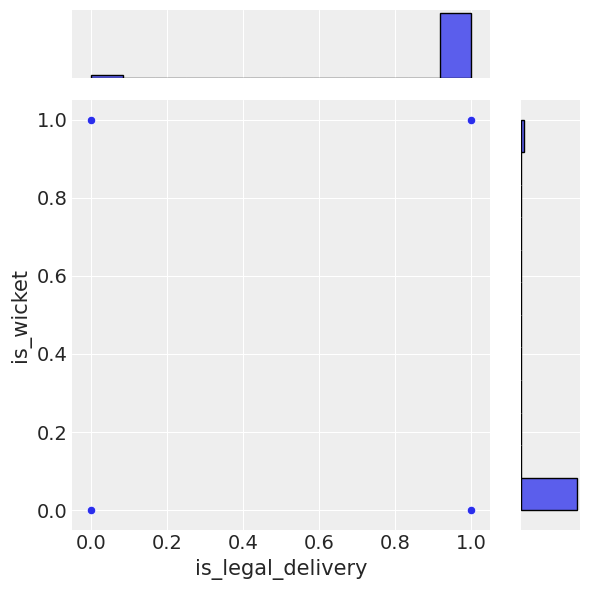

In [53]:
sns.jointplot(
    x = data.is_legal_delivery,
    y = data.is_wicket
)

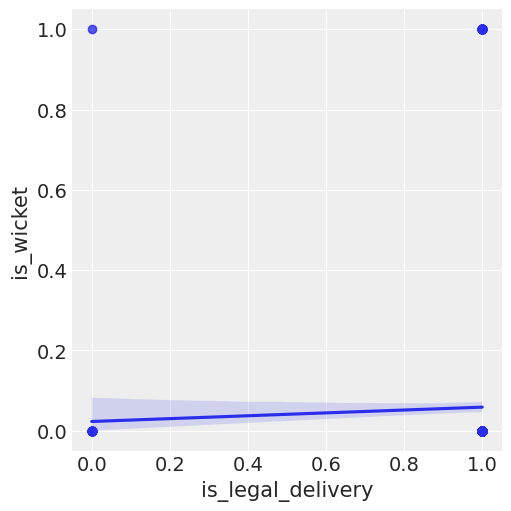

In [52]:
sns.lmplot(
    data = data,
    x = 'is_legal_delivery',
    y = 'is_wicket'
)

In [54]:
COORDS

{'bowling_outcomes': Index(['0', '1-b', '1-b,1-nb', '1-b,1-nb,W-dro', '1-b,1-nb,W-idro', '1-b,1-w',
        '1-b,12-oe', '1-b,2-oe', '1-b,2-oe,W-dro', '1-b,2-oe,W-others',
        '1-b,5-oe', '1-b,6-oe', '1-b,W-dro', '1-b,W-idro', '1-b,W-others',
        '1-nb', '1-nb,W-dro', '1-nb,W-idro', '1-nb,W-others', '1-oe',
        '1-oe,W-dro', '1-oe,W-idro', '1-oe,W-others', '1-w', '1-w,W-bs',
        '1-w,W-dro', '1-w,W-idro', '1-w,W-others', '2-b', '2-b,1-nb',
        '2-b,2-oe', '2-b,5-oe', '2-b,6-oe', '2-b,W-dro', '2-b,W-idro',
        '2-b,W-others', '2-nb', '2-oe', '2-oe,W-dro', '2-oe,W-others', '3-b',
        '3-b,1-nb', '3-b,2-oe', '3-b,W-dro', '3-b,W-idro', '3-b,W-others',
        '3-nb', '3-oe', '4-b', '4-b,1-nb', '4-b,2-oe', '4-b,W-dro',
        '4-b,W-idro', '4-b,W-others', '4-nb', '4-oe', '5-b', '5-nb', '5-oe',
        '5-oe,W-others', '6-b', '6-b,1-nb', '6-b,2-oe', '6-b,6-oe',
        '6-b,W-others', '6-oe', '7-b', '7-oe', 'W-b', 'W-bc', 'W-bs', 'W-dro',
        'W-idro', 'W-oth

In [55]:
COORDS['is_legal_outcomes'] = [True, False]

In [71]:
with pm.Model(coords=COORDS) as first_innings_model:
    first_innings_model.add_coord('ball_ids',
                                   values = np.arange(train_first_innings_dfs[0].shape[0]),
                                   mutable = True)
    batter_runs_outcomes_data = pm.MutableData("batter_runs_outcomes_data",
                                          train_batter_runs_outcomes_idx,
                                          dims = 'ball_ids')
    is_legal_outcomes_data = pm.MutableData("is_legal_outcomes_data",
                                            train_first_innings_dfs[0].is_legal_delivery.values,
                                            dims = 'ball_ids')
    balls_idx_ = pm.MutableData("balls_idx",
                                np.zeros(shape = (train_first_innings_dfs[1].shape[0],
                                                 batter_runs_outcomes.shape[0])),
                                dims = ('ball_ids','batter_runs_outcomes'))
    aggregate_stats_data = pm.MutableData('aggregate_stats_data',
                                         train_first_innings_dfs[1][['wickets_fallen',
                                                                     'current_total', 
                                                                     'total_balls_bowled']].values)

In [72]:
with first_innings_model:
    intercept_mu_is_legal_rv = pm.Normal("intercept_mu_is_legal_rv",
                                         sigma=3.0)
    intercept_sigma_is_legal_rv = pm.HalfNormal("intercept_sigma_is_legal_rv",
                                                sigma=1.0)
    alpha_is_legal_outcome_rv = pm.Normal('alpha_is_legal_outcome_rv',
                                         mu=intercept_mu_is_legal_rv,
                                         sigma=intercept_sigma_is_legal_rv,
                                         dims='is_legal_outcomes')
    beta_agg_stats_for_is_legal_rv = pm.Normal('beta_agg_stats_for_is_legal_rv',
                                   mu = 0,
                                   sigma = 1,
                                   shape = (3, 2))
    mu_is_legal_outcome_rv = pm.Deterministic('mu_is_legal_outcome_rv',
                                                 at.dot(aggregate_stats_data,
                                                        beta_agg_stats_for_is_legal_rv) + alpha_is_legal_outcome_rv,
                                                 dims = ('ball_ids','is_legal_outcomes'))
    probability_of_is_legal_outcome_rv = pm.Deterministic('probability_of_is_legal_outcome_rv',
                                                             at.nnet.softmax(mu_is_legal_outcome_rv),
                                                             dims = ('ball_ids','is_legal_outcomes'))
    is_legal_outcomes_by_ball_and_innings_rv = pm.Categorical('is_legal_outcomes_by_ball_and_innings_rv',
                                                             p=probability_of_is_legal_outcome_rv,
                                                             observed=is_legal_outcomes_data,
                                                             dims = 'ball_ids')


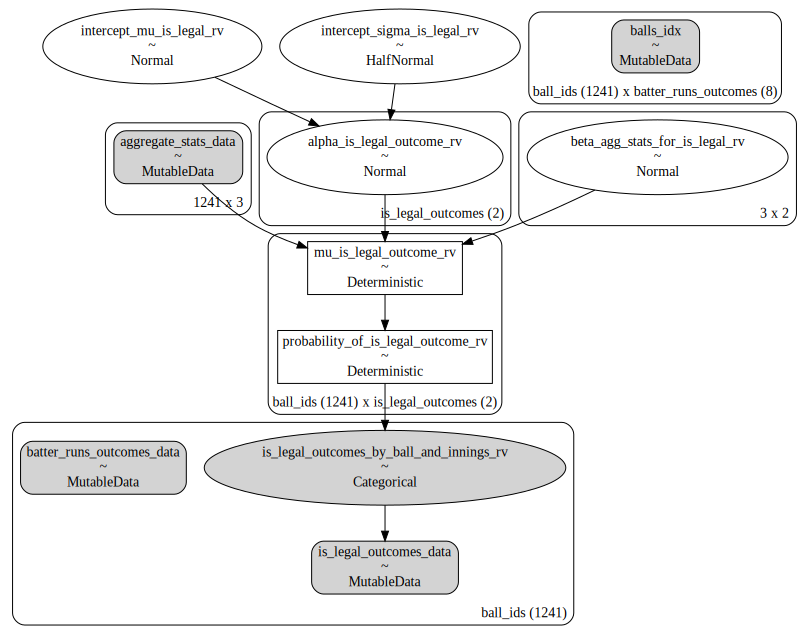

In [73]:
pm.model_to_graphviz(first_innings_model)

In [74]:
with first_innings_model:
    idata = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
2022-11-11 12:34:54.463 INFO    pymc: Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-11-11 12:34:54.464 INFO    pymc: Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
2022-11-11 12:34:59.322 INFO    pymc: Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_mu_is_legal_rv, intercept_sigma_is_legal_rv, alpha_is_legal_outcome_rv, beta_agg_stats_for_is_legal_rv]
2022-11-11 12:34:59.324 INFO    pymc: NUTS: [intercept_mu_is_legal_rv, intercept_sigma_is_legal_rv, alpha_is_legal_outcome_rv, beta_agg_stats_for_is_legal_rv]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1303 seconds.
2022-11-11 12:56:42.466 INFO    pymc: Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1303 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
2022-11-11 12:56:42.474 ERROR   pymc: There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
2022-11-11 12:56:42.491 WARNING pymc: The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
2022-11-11 12:56:42.495 ERROR   pymc: There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept

In [76]:
idata.posterior.coords

Coordinates:
  * chain                                 (chain) int64 0 1 2 3
  * draw                                  (draw) int64 0 1 2 3 ... 997 998 999
  * is_legal_outcomes                     (is_legal_outcomes) bool True False
  * beta_agg_stats_for_is_legal_rv_dim_0  (beta_agg_stats_for_is_legal_rv_dim_0) int64 ...
  * beta_agg_stats_for_is_legal_rv_dim_1  (beta_agg_stats_for_is_legal_rv_dim_1) int64 ...
  * ball_ids                              (ball_ids) int64 0 1 2 ... 1239 1240

In [77]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

array([[<AxesSubplot: title={'center': 'intercept_mu_is_legal_rv'}>,
        <AxesSubplot: title={'center': 'intercept_mu_is_legal_rv'}>]],
      dtype=object)

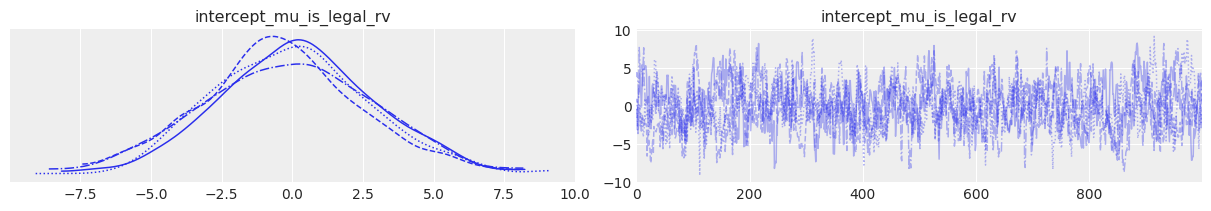

In [79]:
az.plot_trace(idata.posterior.intercept_mu_is_legal_rv)

array([[<AxesSubplot: title={'center': 'intercept_sigma_is_legal_rv'}>,
        <AxesSubplot: title={'center': 'intercept_sigma_is_legal_rv'}>]],
      dtype=object)

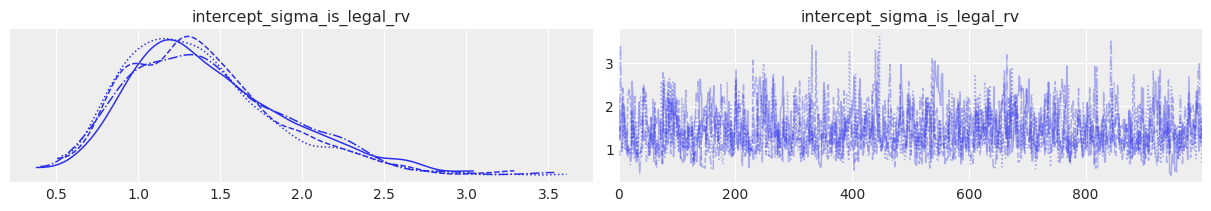

In [80]:
az.plot_trace(idata.posterior.intercept_sigma_is_legal_rv)

array([[<AxesSubplot: title={'center': 'alpha_is_legal_outcome_rv'}>,
        <AxesSubplot: title={'center': 'alpha_is_legal_outcome_rv'}>]],
      dtype=object)

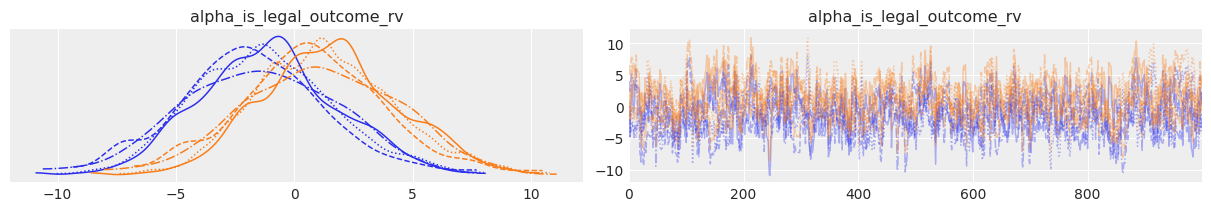

In [81]:
az.plot_trace(idata.posterior.alpha_is_legal_outcome_rv)

array([[<AxesSubplot: title={'center': 'beta_agg_stats_for_is_legal_rv'}>,
        <AxesSubplot: title={'center': 'beta_agg_stats_for_is_legal_rv'}>]],
      dtype=object)

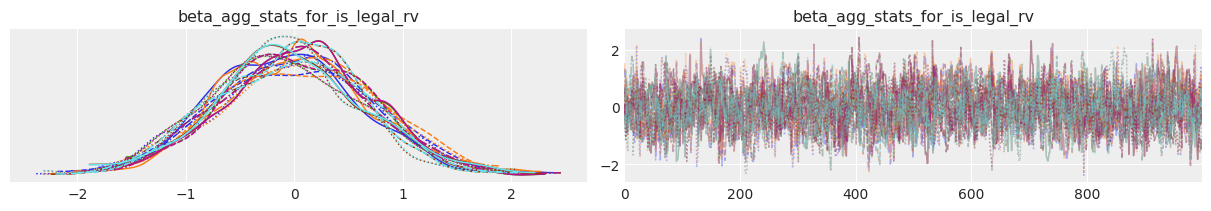

In [82]:
az.plot_trace(idata.posterior.beta_agg_stats_for_is_legal_rv)

In [83]:
az.summary(idata.posterior,
              var_names = ['intercept_sigma_is_legal_rv',
                           'intercept_mu_is_legal_rv',
                           'alpha_is_legal_outcome_rv',
                           'beta_agg_stats_for_is_legal_rv'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept_sigma_is_legal_rv,1.411,0.479,0.617,2.310,0.015,0.011,997.0,1566.0,1.00
intercept_mu_is_legal_rv,-0.080,2.890,-5.344,5.609,0.146,0.103,392.0,743.0,1.00
alpha_is_legal_outcome_rv[True],-1.407,3.064,-7.339,4.250,0.158,0.112,374.0,710.0,1.01
alpha_is_legal_outcome_rv[False],1.191,3.057,-4.236,7.413,0.158,0.112,373.0,723.0,1.01
"beta_agg_stats_for_is_legal_rv[0, 0]",-0.026,0.717,-1.367,1.281,0.035,0.025,428.0,1057.0,1.02
"beta_agg_stats_for_is_legal_rv[0, 1]",0.046,0.717,-1.318,1.332,0.035,0.025,425.0,999.0,1.02
"beta_agg_stats_for_is_legal_rv[1, 0]",-0.006,0.686,-1.252,1.295,0.032,0.023,471.0,1148.0,1.01
"beta_agg_stats_for_is_legal_rv[1, 1]",-0.002,0.686,-1.228,1.317,0.032,0.023,470.0,1167.0,1.01
"beta_agg_stats_for_is_legal_rv[2, 0]",-0.061,0.683,-1.381,1.164,0.032,0.023,443.0,878.0,1.00
"beta_agg_stats_for_is_legal_rv[2, 1]",-0.055,0.683,-1.348,1.192,0.033,0.023,442.0,876.0,1.00


array([<AxesSubplot: title={'center': 'probability_of_is_legal_outcome_rv\nTrue'}>,
       <AxesSubplot: title={'center': 'probability_of_is_legal_outcome_rv\nFalse'}>],
      dtype=object)

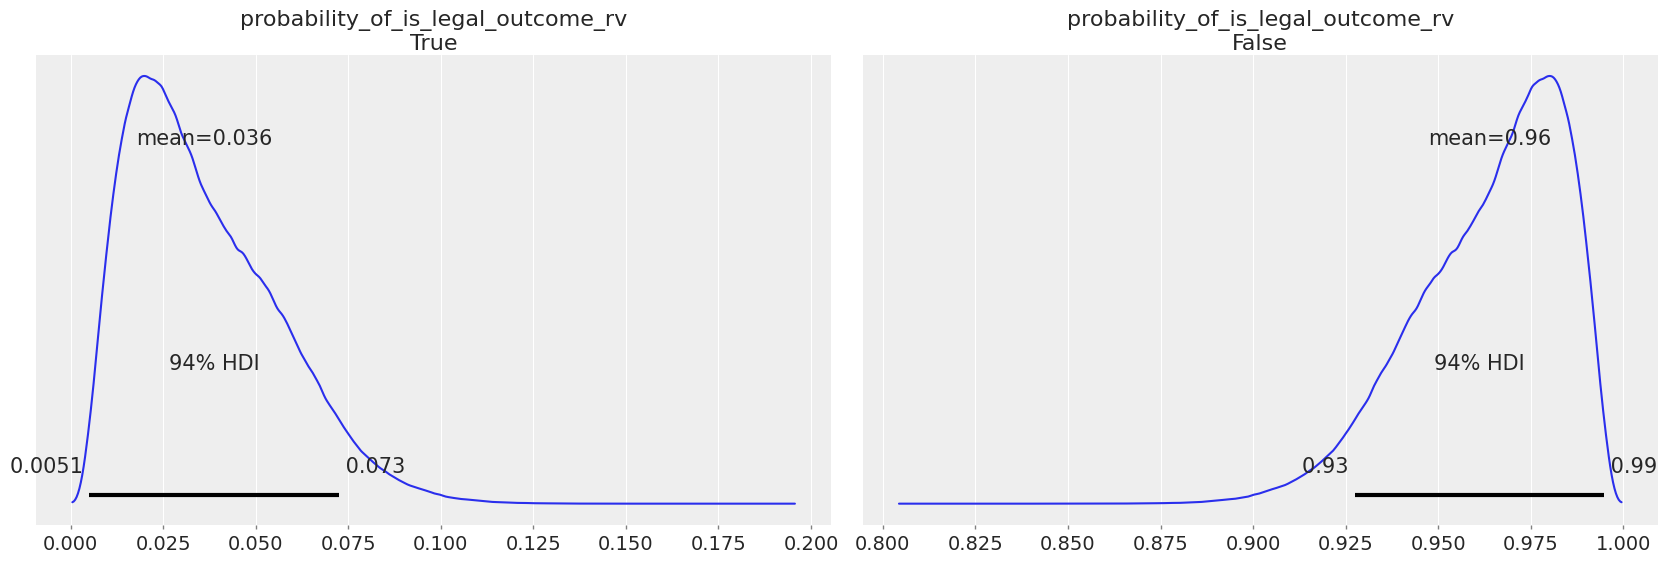

In [84]:
az.plot_posterior(idata.posterior,
                  var_names = ['probability_of_is_legal_outcome_rv'],
                  combine_dims = {'chain','draw','ball_ids'})

<AxesSubplot: >

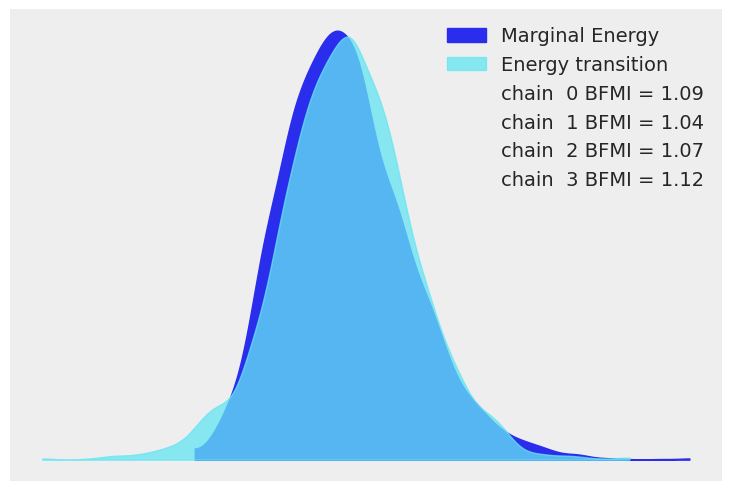

In [86]:
az.plot_energy(idata)

In [87]:
with first_innings_model:
    idata.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
    idata.extend(pm.sample_posterior_predictive(idata,random_seed=RANDOM_SEED))

Sampling: [alpha_is_legal_outcome_rv, beta_agg_stats_for_is_legal_rv, intercept_mu_is_legal_rv, intercept_sigma_is_legal_rv, is_legal_outcomes_by_ball_and_innings_rv]
2022-11-11 13:04:29.569 INFO    pymc: Sampling: [alpha_is_legal_outcome_rv, beta_agg_stats_for_is_legal_rv, intercept_mu_is_legal_rv, intercept_sigma_is_legal_rv, is_legal_outcomes_by_ball_and_innings_rv]
Sampling: [is_legal_outcomes_by_ball_and_innings_rv]
2022-11-11 13:04:59.867 INFO    pymc: Sampling: [is_legal_outcomes_by_ball_and_innings_rv]


<AxesSubplot: xlabel='is_legal_outcomes_by_ball_and_innings_rv / is_legal_outcomes_by_ball_and_innings_rv'>

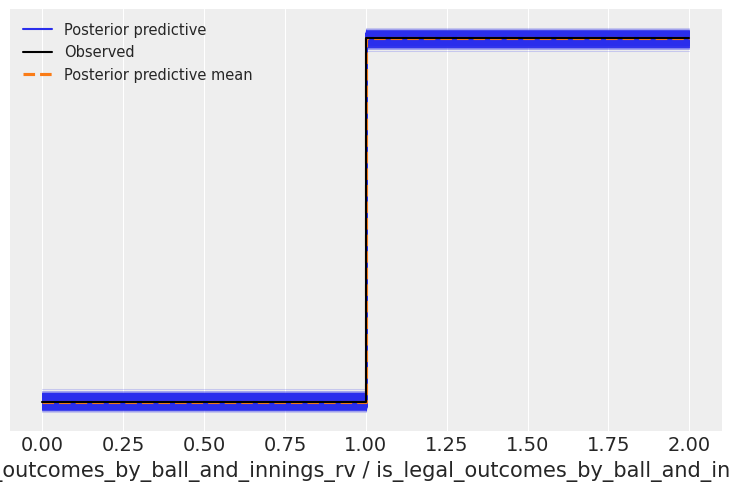

In [88]:
az.plot_ppc(idata)

In [89]:
test_batter_runs_outcomes_idx = pd.Categorical(test_first_innings_dfs[0].batter_runs,
                                               categories = batter_runs_outcomes).codes

In [90]:
first_innings_model.set_dim('ball_ids',
                             test_first_innings_dfs[0].shape[0],
                             coord_values = np.arange(train_first_innings_dfs[0].shape[0],
                                                      train_first_innings_dfs[0].shape[0]+test_first_innings_dfs[0].shape[0]))

In [ ]:
first_innings_model.set_dim('ball_ids',
                             test_first_innings_dfs[0].shape[0],
                             coord_values = np.arange(train_first_innings_dfs[0].shape[0],
                                                      train_first_innings_dfs[0].shape[0]+test_first_innings_dfs[0].shape[0]))

In [91]:
test_first_innings_dfs[0].shape

(12327, 20)

In [92]:
test_batter_runs_outcomes_idx.shape

(12327,)

In [93]:
add_is_legal(test_first_innings_dfs[0])

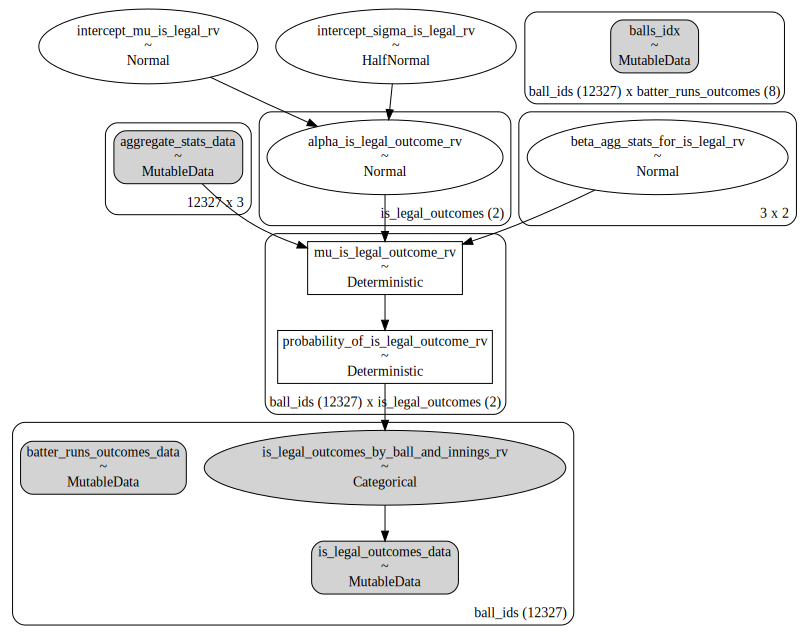

In [96]:
with first_innings_model:
    pm.set_data({
        'batter_runs_outcomes_data': test_batter_runs_outcomes_idx,
        'is_legal_outcomes_data': test_first_innings_dfs[0].is_legal_delivery.values,
        'balls_idx': np.zeros(shape = (test_batter_runs_outcomes_idx.shape[0],
                                       batter_runs_outcomes.shape[0])),
        'aggregate_stats_data': test_first_innings_dfs[1][['wickets_fallen','current_total','total_balls_bowled']].values
    })

pm.model_to_graphviz(first_innings_model)

In [97]:
with first_innings_model:
    idata = pm.sample_posterior_predictive(
            idata,
            predictions=True,
            extend_inferencedata=True,
            random_seed=RANDOM_SEED,
    )

Sampling: [is_legal_outcomes_by_ball_and_innings_rv]
2022-11-11 13:08:48.267 INFO    pymc: Sampling: [is_legal_outcomes_by_ball_and_innings_rv]


In [99]:
y_true = test_first_innings_dfs[0].is_legal_delivery.values

array([[<AxesSubplot: title={'center': 'is_legal_outcomes_by_ball_and_innings_rv\n1241'}>,
        <AxesSubplot: title={'center': 'is_legal_outcomes_by_ball_and_innings_rv\n1242'}>,
        <AxesSubplot: title={'center': 'is_legal_outcomes_by_ball_and_innings_rv\n1243'}>,
        <AxesSubplot: title={'center': 'is_legal_outcomes_by_ball_and_innings_rv\n1244'}>],
       [<AxesSubplot: title={'center': 'is_legal_outcomes_by_ball_and_innings_rv\n1245'}>,
        <AxesSubplot: title={'center': 'is_legal_outcomes_by_ball_and_innings_rv\n1246'}>,
        <AxesSubplot: title={'center': 'is_legal_outcomes_by_ball_and_innings_rv\n1247'}>,
        <AxesSubplot: title={'center': 'is_legal_outcomes_by_ball_and_innings_rv\n1248'}>],
       [<AxesSubplot: title={'center': 'is_legal_outcomes_by_ball_and_innings_rv\n1249'}>,
        <AxesSubplot: title={'center': 'is_legal_outcomes_by_ball_and_innings_rv\n1250'}>,
        <AxesSubplot: title={'center': 'is_legal_outcomes_by_ball_and_innings_rv\n1251'}

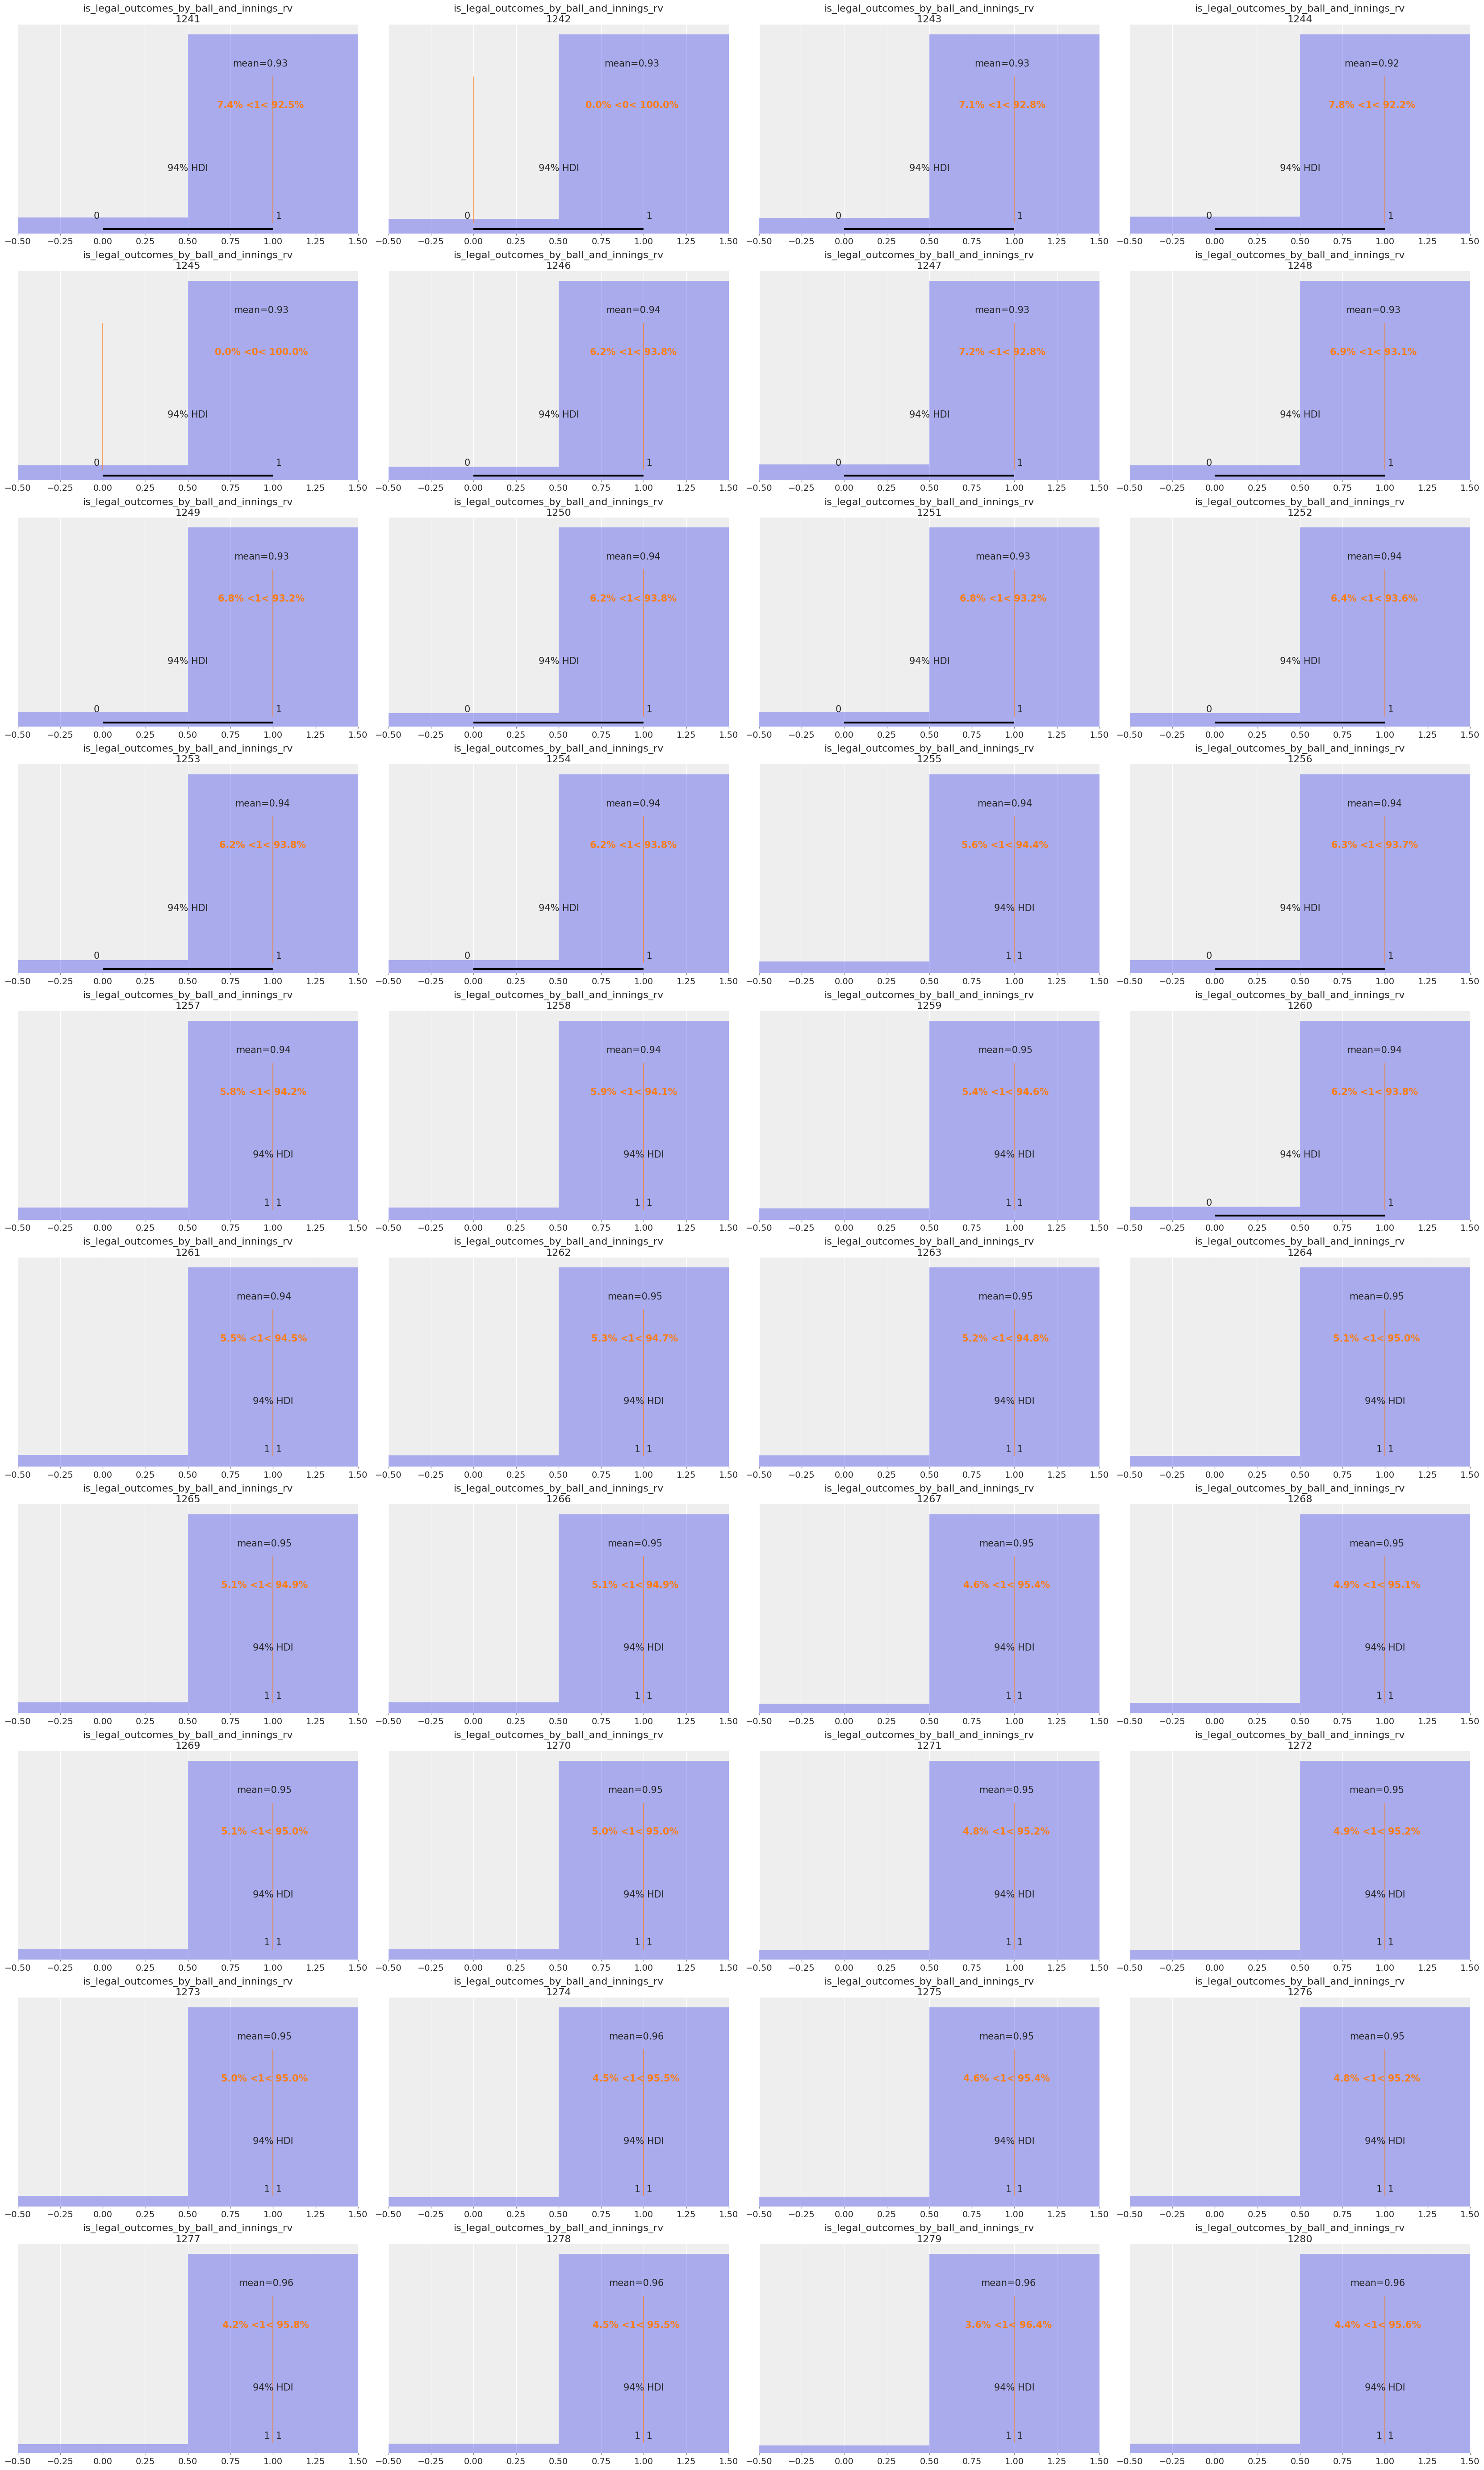

In [101]:
az.plot_posterior(
    idata.predictions,
    ref_val=y_true.tolist(),
)

In [102]:
def predictions_from_idata(idata,
                           var_name):
    preds_helper = lambda ds: ds.to_dataframe()[var_name].value_counts().to_xarray()
    predictions = (
        idata.predictions[var_name]
        .stack(dims=['chain','draw'])
        .groupby('ball_ids')
        .apply(preds_helper)
        .argmax('index')
    )
    return predictions
    

In [104]:
predictions = predictions_from_idata(idata,
                                     'is_legal_outcomes_by_ball_and_innings_rv')

In [106]:
from sklearn.metrics import classification_report

In [109]:
cr = classification_report(y_true,
                           1-predictions)

In [110]:
# Classification Report with wickets fallen, current total, total balls bowled
print(cr)

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       460
        True       0.96      1.00      0.98     11867

    accuracy                           0.96     12327
   macro avg       0.48      0.50      0.49     12327
weighted avg       0.93      0.96      0.94     12327



In [508]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_batter_runs_outcomes_idx,
                      predictions)

In [509]:
pd.DataFrame(cm)

,0,1,2,3,4,5,6
0,3769,1445,0,0,0,0,14
1,2332,1859,0,0,0,0,23
2,386,441,0,0,0,0,10
3,35,17,0,0,0,0,0
4,859,561,0,0,0,0,13
5,4,0,0,0,0,0,0
6,188,354,0,0,0,0,17


In [498]:
from sklearn.svm import SVC
clf = SVC(random_state=0)
clf.fit(train_first_innings_dfs[1][['wickets_fallen',
                                   'current_total',
                                   'total_balls_bowled']], 
        train_batter_runs_outcomes_idx)

SVC(random_state=0)

In [500]:
predictions_svc = clf.predict(test_first_innings_dfs[1][['wickets_fallen',
                                   'current_total',
                                   'total_balls_bowled']])

In [501]:
cr = classification_report(test_batter_runs_outcomes_idx,
                           predictions_svc)

In [502]:
print(cr)

              precision    recall  f1-score   support

           0       0.51      0.61      0.55      5228
           1       0.40      0.56      0.47      4214
           2       0.00      0.00      0.00       837
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00      1433
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00       559

    accuracy                           0.45     12327
   macro avg       0.13      0.17      0.15     12327
weighted avg       0.35      0.45      0.39     12327



In [503]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(train_first_innings_dfs[1][['wickets_fallen',
                                   'current_total',
                                   'total_balls_bowled']], 
        train_batter_runs_outcomes_idx)

RandomForestClassifier(random_state=0)

In [504]:
predictions_rfc = clf.predict(test_first_innings_dfs[1][['wickets_fallen',
                                   'current_total',
                                   'total_balls_bowled']])

In [505]:
cr = classification_report(test_batter_runs_outcomes_idx,
                           predictions_svc)

In [506]:
print(cr)

              precision    recall  f1-score   support

           0       0.51      0.61      0.55      5228
           1       0.40      0.56      0.47      4214
           2       0.00      0.00      0.00       837
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00      1433
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00       559

    accuracy                           0.45     12327
   macro avg       0.13      0.17      0.15     12327
weighted avg       0.35      0.45      0.39     12327

